# Blood Cell Subtype Classification Part 2: Transfer Learning using a finetuned Densenet201 model. 

For Part 1 please follow [this link](https://www.kaggle.com/kbrans/cnn-91-6-acc-with-new-train-val-test-splits). A lot of the code from Part 1 has been repeated in this notebook, and the explanations and commentary for some design decisions can be found there (e.g new Train/Val/Test splits). 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from tensorflow.keras.applications import MobileNetV2
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Loading data

In [2]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (150,150)

In [3]:
def load_data():

    datasets = ['/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN','/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST' ]
    images = []
    labels = []

    # iterate through training and test sets
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the| img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [4]:
images, labels = load_data()

100%|██████████| 623/623 [00:03<00:00, 158.10it/s]


In [5]:


images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

# Data Exploration

In [6]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Validation images are of shape: {}".format(val_images.shape))
print("Validation labels are of shape: {}".format(val_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))

Number of training examples: 9955
Number of validation examples: 1245
Number of testing examples: 1244
Training images are of shape: (9955, 150, 150, 3)
Training labels are of shape: (9955,)
Validation images are of shape: (1245, 150, 150, 3)
Validation labels are of shape: (1245,)
Test images are of shape: (1244, 150, 150, 3)
Test labels are of shape: (1244,)


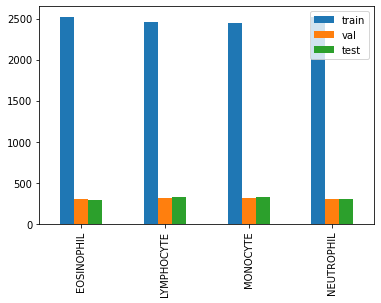

In [7]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

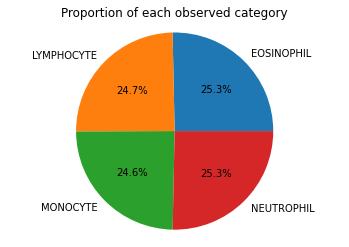

In [8]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [9]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

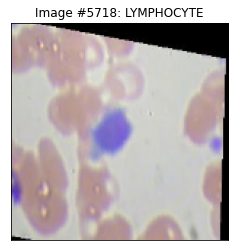

In [10]:
def display_random_image (class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

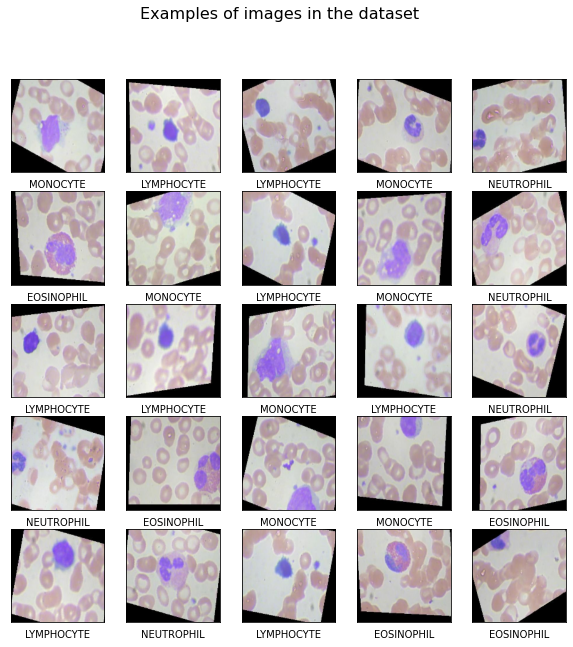

In [11]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

# Model build and training 

In [12]:
### Model number 2: Fine tuned Densenet201 model 

# Copy Densenet201 model and remove fully connected layers 

densenet_model = MobileNetV2(
    include_top = False,
    weights = 'imagenet', 
    input_tensor = None, 
    input_shape = (150,150,3), 
    pooling = None
)

# Option here to train on the final Conv5 block in the densenet model ("True") or use imagenet weights for this layer ("False")

densenet_model.trainable = True

for layer in densenet_model.layers:
  if 'conv5' in layer.name:
    layer.trainable = False
  else:
    layer.trainable = False

# 3 fully connected layers are added, with 256, 128 and 64 units respectively
# Dropout and Batch Normalization are performed on the fully connected layers.

input = Input(shape = (150,150,3))
layer = densenet_model(inputs=input)
layer = Flatten()(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=256, activation='relu')(layer)
layer = Dropout(0.7)(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=128, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=64, activation='relu')(layer)
layer = Dropout(0.3)(layer)
layer = Dense(units=4,activation='softmax')(layer)

model2 = Model(inputs=input, outputs=layer)

model2.summary()

model2.compile(loss='sparse_categorical_crossentropy',
            optimizer= 'adam',
            metrics=['accuracy'])

# Implement callbacks 
checkpoint = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)


2022-11-22 12:26:18.204895: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 12:26:18.328694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 12:26:18.329876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 12:26:18.332063: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32000)             128000    
_________________________________________________________________
dense (Dense)                (None, 256)               8192256   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
________________________________________________________________

In [13]:
# Train model 

history2 = model2.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 25, 
    validation_data =(val_images, val_labels) , 
    callbacks=[learning_rate_reduction])

2022-11-22 12:26:30.566106: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2687850000 exceeds 10% of free system memory.
2022-11-22 12:26:34.224848: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2687850000 exceeds 10% of free system memory.
2022-11-22 12:26:36.395895: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-11-22 12:26:39.865328: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


312/312 [==============================] - ETA: 0s - loss: 1.4342 - accuracy: 0.3386

2022-11-22 12:26:51.231041: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 336150000 exceeds 10% of free system memory.
2022-11-22 12:26:51.405937: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 336150000 exceeds 10% of free system memory.


312/312 [==============================] - 17s 27ms/step - loss: 1.4342 - accuracy: 0.3386 - val_loss: 1.1574 - val_accuracy: 0.5357
Epoch 2/25
312/312 [==============================] - 6s 21ms/step - loss: 1.1703 - accuracy: 0.4753 - val_loss: 0.8912 - val_accuracy: 0.6273
Epoch 3/25
312/312 [==============================] - 7s 22ms/step - loss: 0.9963 - accuracy: 0.5678 - val_loss: 0.7333 - val_accuracy: 0.7012
Epoch 4/25
312/312 [==============================] - 6s 20ms/step - loss: 0.8746 - accuracy: 0.6326 - val_loss: 0.6592 - val_accuracy: 0.7229
Epoch 5/25
312/312 [==============================] - 7s 21ms/step - loss: 0.7769 - accuracy: 0.6794 - val_loss: 0.5981 - val_accuracy: 0.7486
Epoch 6/25
312/312 [==============================] - 7s 21ms/step - loss: 0.7318 - accuracy: 0.7032 - val_loss: 0.5604 - val_accuracy: 0.7751
Epoch 7/25
312/312 [==============================] - 6s 21ms/step - loss: 0.6961 - accuracy: 0.7172 - val_loss: 0.5697 - val_accuracy: 0.7767
Epoch 8/2

# Model Evaluation

In [14]:
# Create Accuracy and Loss chart function

def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(25)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

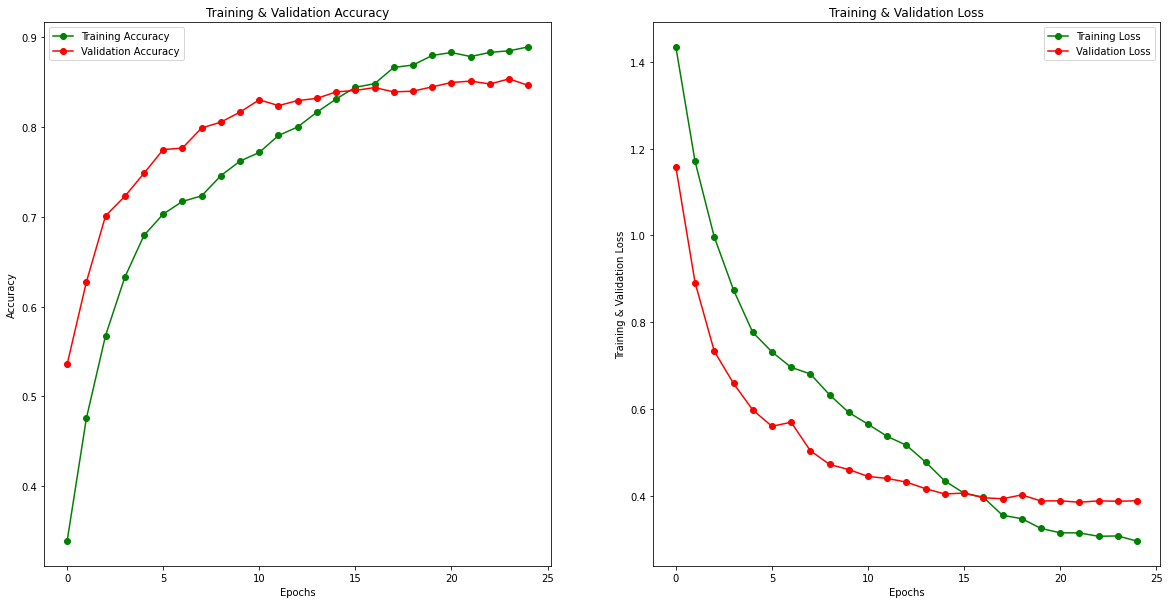

In [15]:
# Accuracy and Loss charts for Model 2

plot_accuracy_loss_chart(history2)

In [16]:
# Save model 

model2.save("bloodcell_densenet201_10epochs_lrreduction.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [17]:
# Evaluating the model on the test data

results = model2.evaluate(test_images, test_labels)

print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

2022-11-22 12:30:09.836007: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 335880000 exceeds 10% of free system memory.


39/39 [==============================] - 1s 23ms/step - loss: 0.3361 - accuracy: 0.8722
Loss of the model is -  0.3361012041568756
Accuracy of the model is -  87.21864819526672 %


I was initially puzzled that Validation accuracy exceeded Training accuracy, and that Test accuracy exceeded both of these. I believe this is due to the Dropout layers which randomly set a proportion of unit inputs to 0, thus creating a more robust model that can generalise better to new data in the validation and test sets. 

In [18]:
# Create predictions for test images

predictions2 = model2.predict(test_images)
predictions2 = np.argmax(predictions2,axis=1)
predictions2[:15]

array([2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 2, 1, 3])

In [19]:
from sklearn.metrics import classification_report

print(classification_report(
    test_labels, 
    predictions2, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.81      0.76      0.78       291
LYMPHOCYTE (Class 1)       0.94      0.95      0.94       326
  MONOCYTE (Class 2)       0.90      0.98      0.94       329
NEUTROPHIL (Class 3)       0.81      0.79      0.80       298

            accuracy                           0.87      1244
           macro avg       0.87      0.87      0.87      1244
        weighted avg       0.87      0.87      0.87      1244



In [20]:
# Confusion matrix plot function and execute 

def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    


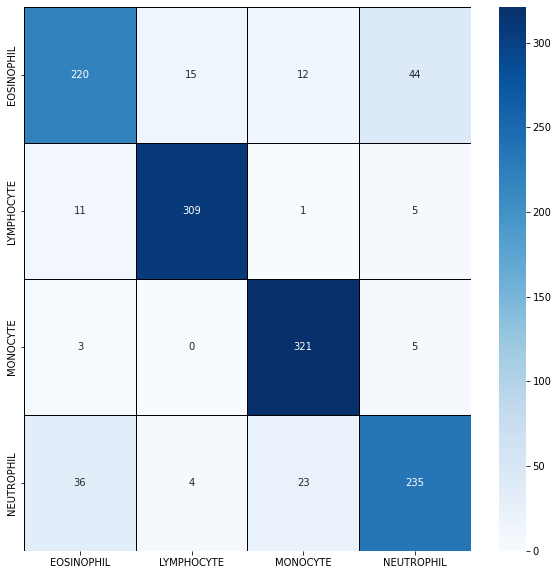

In [21]:
# Plot confusion matrix for Model 2

cm2 = confusion_matrix(test_labels, predictions2)
cm2 = pd.DataFrame(cm2, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
plot_confusion_matrix(cm2)

This Densenet Model shows similar patterns in test results that we saw in Model 1 (created in [Part 1](https://www.kaggle.com/kbrans/cnn-91-6-acc-with-new-train-val-test-splits)). Classification of Lymphocytes and Monocytes are very good with an F1 scores of 0.97 although not as good as in Model 1 (0.98 F1 score), while Neutrophils and Eosinophils and still confused on occasion with each other but fare slightly better than in Model 1. 

# Future Work 

- Create a Finetuned VGG16 model with the same dataset
- Create a Densenet201 model where training occurs on final Conv5 block. 
- Explore optimization techniques and explore changes to hyperparameters (Learning rate, batch size, number of epochs etcs) 

# References 

Some code was adapted from [Carlos Zuluaga](https://medium.com/@carlosz22/transfer-learning-using-keras-with-densenet-169-91679300f94a), [Vincee](https://www.kaggle.com/vincee/intel-image-classification-cnn-keras) and [Abhinav Sagar](https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8)